# Ordinary Kriging - Synthetic Dataset (SR1)

https://photutils.readthedocs.io/en/stable/api/photutils.utils.ShepardIDWInterpolator.html

https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

## Importing packages and loading necessary datasets

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import skgstat as skg

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


# 200 points calibration

In [6]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal200.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal200.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal200.csv')

In [7]:
# Initialize an empty dictionary for storing scores
cv_score_list_200_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_200_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_200_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_200_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


spherical  exponential  gaussian    matern  \
Validation Score MAE           0.566097     0.536272  0.599174  0.591844   
Validation Score RMSE          0.715735     0.678445  0.757931  0.748250   
Validation Score MAPE          4.105606     3.761276  4.427016  4.414091   
Validation Score R Squared     0.580283     0.622878  0.529336  0.541283   
Validation Score Kriging Var   0.542300     0.404586  0.521915  0.511474   

                                stable     cubic  
Validation Score MAE          0.535497  0.600286  
Validation Score RMSE         0.677644  0.759815  
Validation Score MAPE         3.788233  4.371302  
Validation Score R Squared    0.623769  0.526993  
Validation Score Kriging Var  0.380990  0.545581

The smallest Validation Score MAE is 0.535497433173101, found in model stable.
The smallest Validation Score RMSE is 0.6776440072346276, found in model stable.
The smallest Validation Score MAPE is 3.761276492519278, found in model exponential.
The largest Validation Score R Squared is 0.6237686999171875, found in model stable.
The smallest Validation Score Kriging Var is 0.3809898288103659, found in model stable.
Validation Computation Time: 5.48 seconds


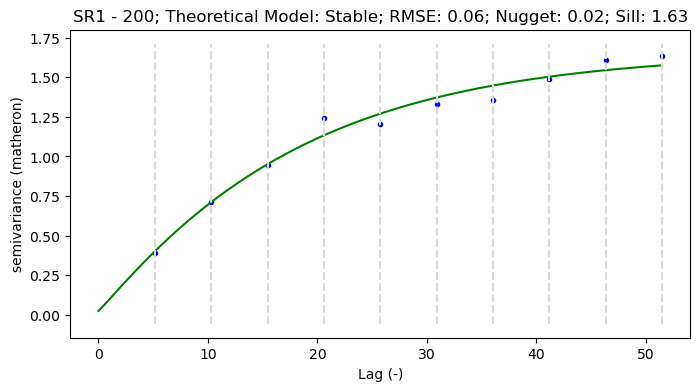

In [8]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'stable')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 200; Theoretical Model: Stable; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

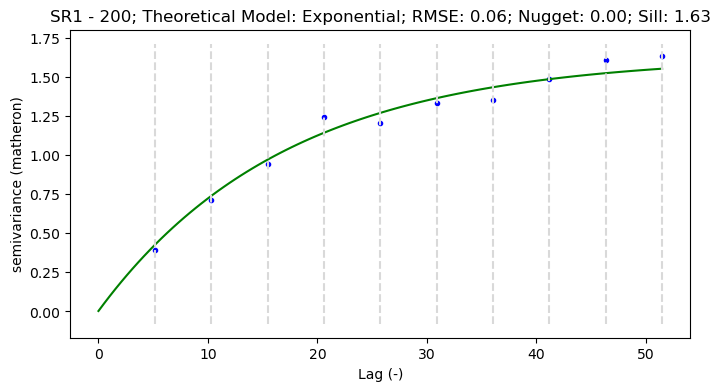

In [10]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'exponential')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 200; Theoretical Model: Exponential; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

# 400 points calibration

In [11]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal400.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal400.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal400.csv')

In [12]:
# Initialize an empty dictionary for storing scores
cv_score_list_400_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_400_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_400_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_400_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

spherical  exponential  gaussian    matern  \
Validation Score MAE           0.516961     0.521223  0.542849  0.537825   
Validation Score RMSE          0.651560     0.656281  0.685236  0.678759   
Validation Score MAPE          4.224505     4.274045  4.335269  4.334474   
Validation Score R Squared     0.652175     0.647116  0.615291  0.622529   
Validation Score Kriging Var   0.359297     0.356052  0.425462  0.412445   

                                stable     cubic  
Validation Score MAE          0.517924  0.539363  
Validation Score RMSE         0.652083  0.681075  
Validation Score MAPE         4.245209  4.275115  
Validation Score R Squared    0.651617  0.619949  
Validation Score Kriging Var  0.288132  0.432860

The smallest Validation Score MAE is 0.516960975328223, found in model spherical.
The smallest Validation Score RMSE is 0.6515601099745654, found in model spherical.
The smallest Validation Score MAPE is 4.224504739487122, found in model spherical.
The largest Validation Score R Squared is 0.6521750789792745, found in model spherical.
The smallest Validation Score Kriging Var is 0.2881318706778784, found in model stable.
Validation Computation Time: 4.35 seconds


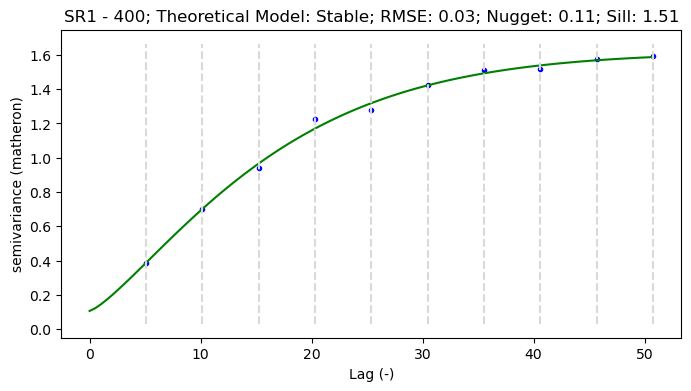

In [13]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'stable')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 400; Theoretical Model: Stable; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

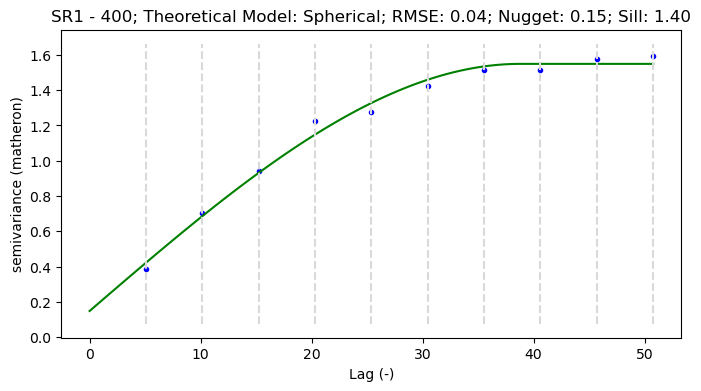

In [14]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'spherical')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 400; Theoretical Model: Spherical; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

# 600 points calibration

In [15]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal600.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal600.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal600.csv')

In [16]:
# Initialize an empty dictionary for storing scores
cv_score_list_600_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_600_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_600_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_600_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


spherical  exponential  gaussian    matern  \
Validation Score MAE           0.495397     0.501121  0.519474  0.514895   
Validation Score RMSE          0.623166     0.629859  0.655834  0.650041   
Validation Score MAPE          3.929532     4.090173  3.838182  3.853879   
Validation Score R Squared     0.681830     0.674959  0.647597  0.653795   
Validation Score Kriging Var   0.342791     0.311836  0.408566  0.395911   

                                stable     cubic  
Validation Score MAE          0.499827  0.516178  
Validation Score RMSE         0.627996  0.651741  
Validation Score MAPE         4.063100  3.811244  
Validation Score R Squared    0.676879  0.651982  
Validation Score Kriging Var  0.252286  0.416189

The smallest Validation Score MAE is 0.49539737142550755, found in model spherical.
The smallest Validation Score RMSE is 0.6231660253430115, found in model spherical.
The smallest Validation Score MAPE is 3.8112442366583656, found in model cubic.
The largest Validation Score R Squared is 0.6818299802093515, found in model spherical.
The smallest Validation Score Kriging Var is 0.2522855744176172, found in model stable.
Validation Computation Time: 4.50 seconds


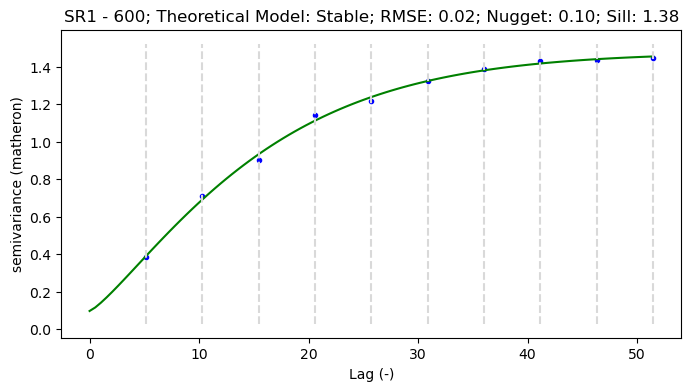

In [17]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'stable')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 600; Theoretical Model: Stable; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

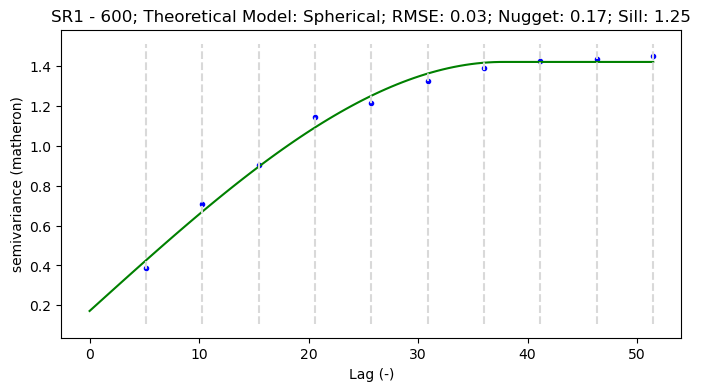

In [18]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'spherical')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 600; Theoretical Model: Spherical; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

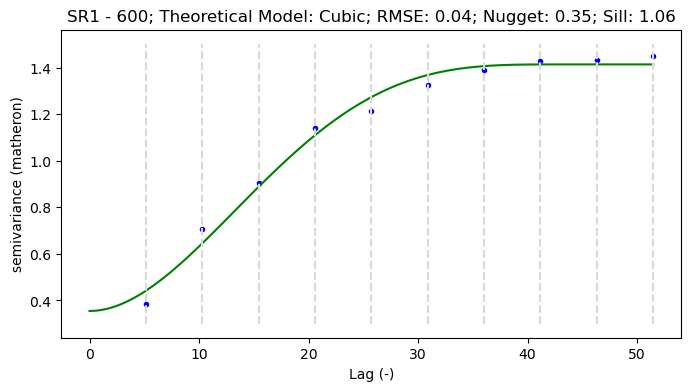

In [19]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'cubic')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 600; Theoretical Model: Cubic; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

# 800 points calibration

In [20]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal800.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal800.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal800.csv')

In [21]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_800_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_800_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


spherical  exponential  gaussian    matern  \
Validation Score MAE           0.481072     0.490289  0.502801  0.498963   
Validation Score RMSE          0.606001     0.619267  0.632699  0.627781   
Validation Score MAPE          3.707856     3.915808  3.621552  3.593599   
Validation Score R Squared     0.699116     0.685799  0.672021  0.677100   
Validation Score Kriging Var   0.323070     0.267782  0.393793  0.380823   

                                stable     cubic  
Validation Score MAE          0.500023  0.499711  
Validation Score RMSE         0.632075  0.628925  
Validation Score MAPE         4.024857  3.600573  
Validation Score R Squared    0.672668  0.675923  
Validation Score Kriging Var  0.183744  0.400165

The smallest Validation Score MAE is 0.481071976593621, found in model spherical.
The smallest Validation Score RMSE is 0.6060010087124137, found in model spherical.
The smallest Validation Score MAPE is 3.593598529022384, found in model matern.
The largest Validation Score R Squared is 0.6991164715091354, found in model spherical.
The smallest Validation Score Kriging Var is 0.18374367511755899, found in model stable.
Validation Computation Time: 4.74 seconds


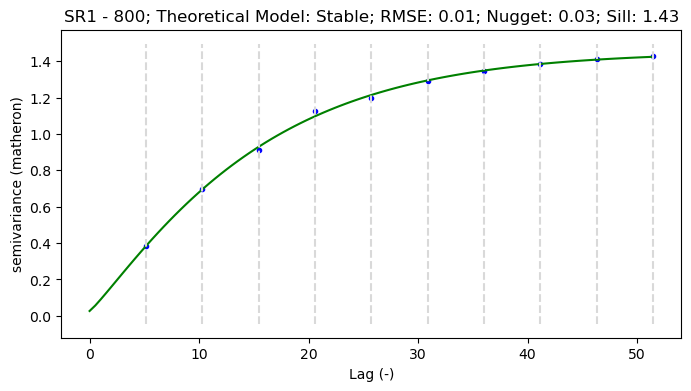

In [22]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'stable')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 800; Theoretical Model: Stable; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

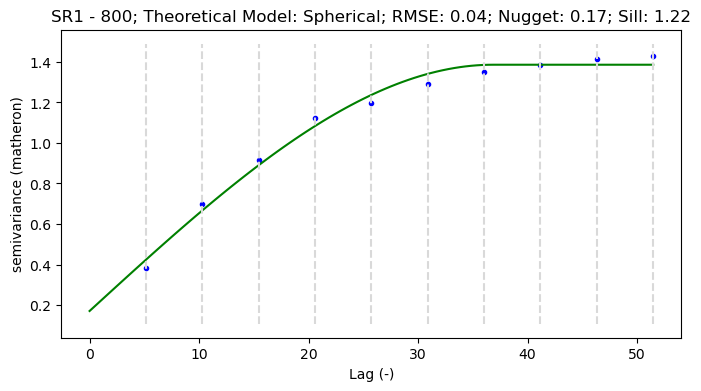

In [23]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'spherical')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 800; Theoretical Model: Spherical; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

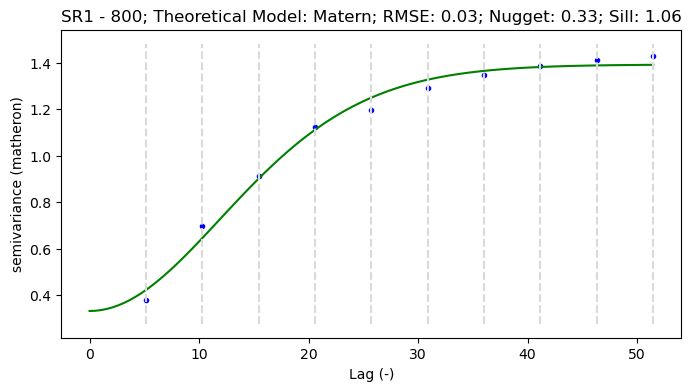

In [24]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'matern')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 800; Theoretical Model: Matern; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

# 1000 points calibration

In [25]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal1000.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal1000.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal1000.csv')

In [26]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_1000_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_1000_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


spherical  exponential  gaussian    matern  \
Validation Score MAE           0.463937     0.478228  0.481089  0.477928   
Validation Score RMSE          0.586971     0.605847  0.607399  0.603266   
Validation Score MAPE          3.359806     3.688804  3.316314  3.260405   
Validation Score R Squared     0.717717     0.699269  0.697727  0.701826   
Validation Score Kriging Var   0.283794     0.238189  0.364862  0.351813   

                                stable     cubic  
Validation Score MAE          0.487811  0.478037  
Validation Score RMSE         0.617944  0.603539  
Validation Score MAPE         3.798246  3.268366  
Validation Score R Squared    0.687140  0.701556  
Validation Score Kriging Var  0.158279  0.369532

The smallest Validation Score MAE is 0.46393711677828414, found in model spherical.
The smallest Validation Score RMSE is 0.5869705732800335, found in model spherical.
The smallest Validation Score MAPE is 3.2604052775593155, found in model matern.
The largest Validation Score R Squared is 0.7177172252520183, found in model spherical.
The smallest Validation Score Kriging Var is 0.15827948075660744, found in model stable.
Validation Computation Time: 5.29 seconds


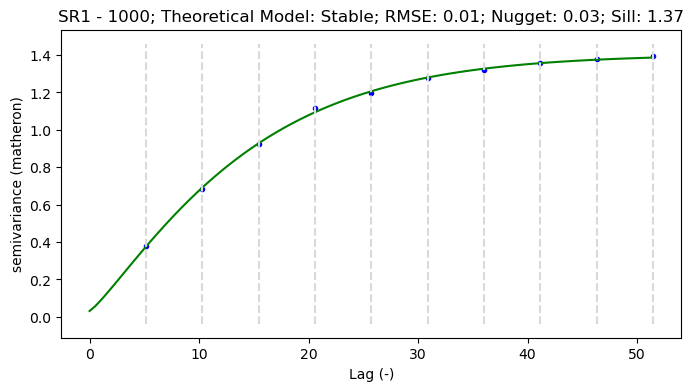

In [27]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'stable')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 1000; Theoretical Model: Stable; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

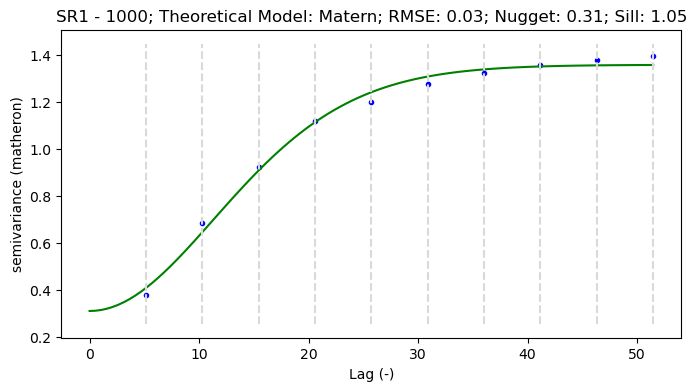

In [28]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'matern')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 1000; Theoretical Model: Matern; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

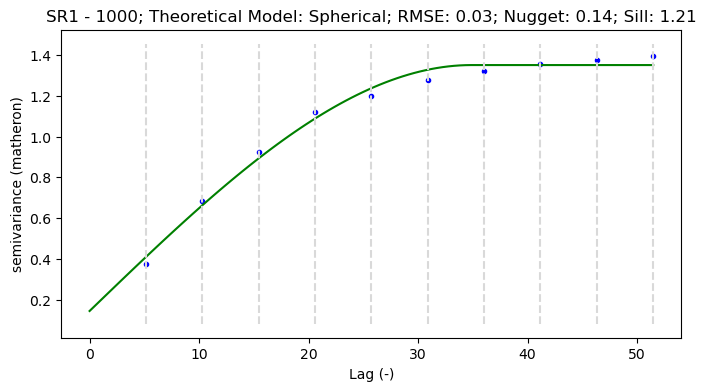

In [29]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'spherical')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 1000; Theoretical Model: Spherical; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

# 1500 points calibration

In [30]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal1500.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal1500.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal1500.csv')

In [31]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_1500_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_1500_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


spherical  exponential  gaussian    matern  \
Validation Score MAE           0.453737     0.477987  0.463840  0.461974   
Validation Score RMSE          0.572226     0.602058  0.584529  0.582070   
Validation Score MAPE          3.405396     3.791608  3.192934  3.185705   
Validation Score R Squared     0.731721     0.703019  0.720061  0.722411   
Validation Score Kriging Var   0.258767     0.178437  0.348033  0.334738   

                                stable     cubic  
Validation Score MAE          0.496513  0.461284  
Validation Score RMSE         0.624735  0.581340  
Validation Score MAPE         3.986131  3.195516  
Validation Score R Squared    0.680226  0.723107  
Validation Score Kriging Var  0.109297  0.349182

The smallest Validation Score MAE is 0.4537371889791614, found in model spherical.
The smallest Validation Score RMSE is 0.5722261019534894, found in model spherical.
The smallest Validation Score MAPE is 3.185705304543781, found in model matern.
The largest Validation Score R Squared is 0.7317207721888599, found in model spherical.
The smallest Validation Score Kriging Var is 0.1092973317908004, found in model stable.
Validation Computation Time: 6.11 seconds


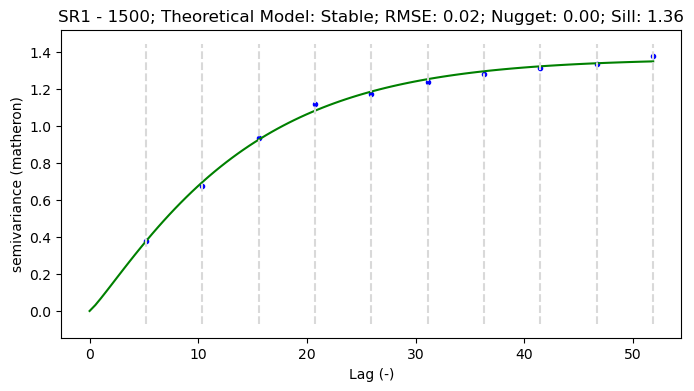

In [32]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'stable')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 1500; Theoretical Model: Stable; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

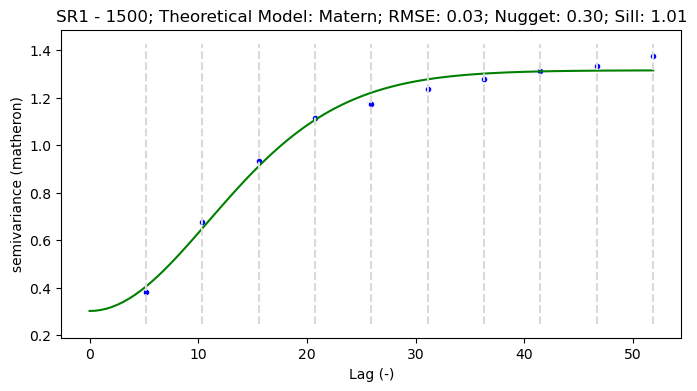

In [33]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'matern')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 1500; Theoretical Model: Matern; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

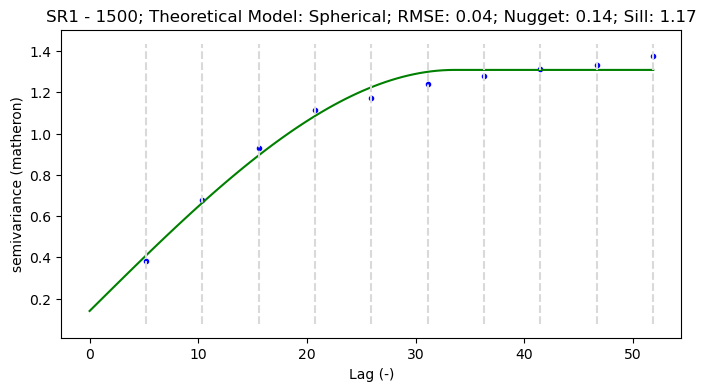

In [34]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'spherical')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 1500; Theoretical Model: Spherical; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

# 2000 points calibration

In [35]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal2000.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal2000.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal2000.csv')

In [36]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_2000_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_2000_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


spherical  exponential  gaussian    matern  \
Validation Score MAE           0.438499     0.461310  0.446340  0.445306   
Validation Score RMSE          0.554375     0.582296  0.564505  0.563146   
Validation Score MAPE          2.543937     3.323454  2.873003  2.845888   
Validation Score R Squared     0.748198     0.722195  0.738912  0.740167   
Validation Score Kriging Var   0.279758     0.175442  0.368476  0.354510   

                                stable     cubic  
Validation Score MAE          0.475981  0.444857  
Validation Score RMSE         0.600810  0.562663  
Validation Score MAPE         3.611755  2.842556  
Validation Score R Squared    0.704250  0.740613  
Validation Score Kriging Var  0.112771  0.372488

The smallest Validation Score MAE is 0.43849929116563235, found in model spherical.
The smallest Validation Score RMSE is 0.5543746385702301, found in model spherical.
The smallest Validation Score MAPE is 2.5439367138851137, found in model spherical.
The largest Validation Score R Squared is 0.7481984336206203, found in model spherical.
The smallest Validation Score Kriging Var is 0.11277131167113921, found in model stable.
Validation Computation Time: 8.06 seconds


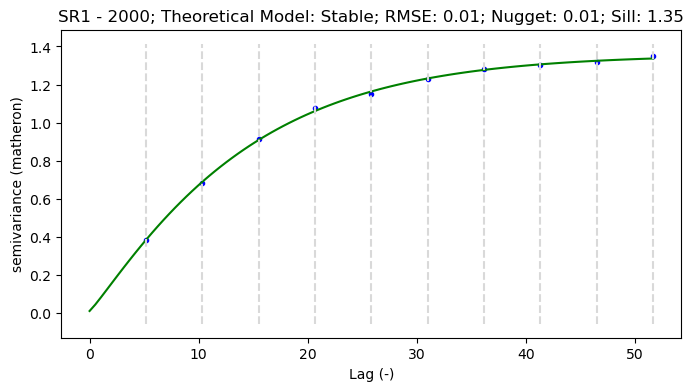

In [37]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'stable')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 2000; Theoretical Model: Stable; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

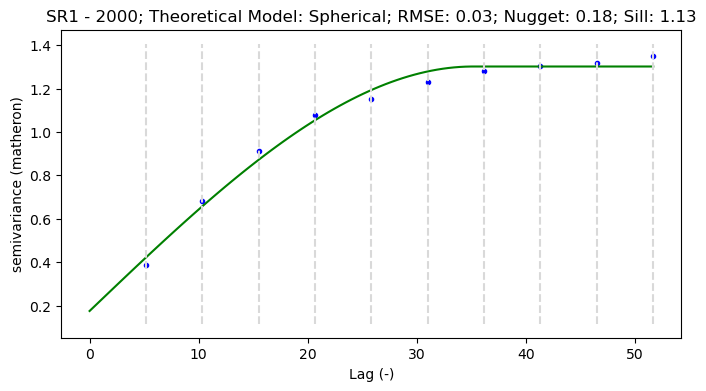

In [38]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'spherical')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1 - 2000; Theoretical Model: Spherical; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

## Validation score as calibration set size increases

In [39]:
def calculate_means(data_structures):
    all_means = {}
    for structure_id, data in enumerate(data_structures, 1):
        means = {key: sum(d[key] for d in data.values()) / len(data) for key in data[next(iter(data))]}
        all_means[f"Structure {structure_id}"] = means
    return all_means

# List of data structures
data_structures_model = [cv_score_list_200_model, cv_score_list_400_model, cv_score_list_600_model, cv_score_list_800_model,cv_score_list_1000_model,cv_score_list_1500_model, cv_score_list_2000_model]

# Calculate means
all_means_model = calculate_means(data_structures_model)

In [40]:
new_keys = [200, 400, 600, 800, 1000, 1500, 2000]

# Function to replace keys
def replace_keys(structures, new_keys):
    # Make sure there are enough new keys for the structures
    if len(new_keys) < len(structures):
        raise ValueError("Not enough new keys for the number of structures")

    # New dictionary to store replaced key structures
    replaced_structures = {}

    # Use zip to iterate over both the items in structures and the new_keys simultaneously
    for new_key, (old_key, value) in zip(new_keys, structures.items()):
        replaced_structures[new_key] = value

    return replaced_structures

all_means_model = replace_keys(all_means_model, new_keys)

In [41]:
cal_size = [200, 400, 600, 800, 1000, 1500, 2000]
all_means_model_df = pd.DataFrame(all_means_model).T
all_means_model_df
#Mean validation score across all theoratical models for differing calibration set sizes

Validation Score MAE  Validation Score RMSE  Validation Score MAPE  \
200               0.571528               0.722970               4.144588   
400               0.529357               0.667499               4.281436   
600               0.507815               0.639773               3.931018   
800               0.495477               0.624458               3.744041   
1000              0.477838               0.604161               3.448657   
1500              0.469223               0.591160               3.459548   
2000              0.452049               0.571299               3.006765   

      Validation Score R Squared  Validation Score Kriging Var  
200                     0.570757                      0.484474  
400                     0.634780                      0.379041  
600                     0.664507                      0.354596  
800                     0.680438                      0.324896  
1000                    0.700873                      0.294412  
1500                    0.713424                      0.263076  
2000                    0.732389                      0.277241

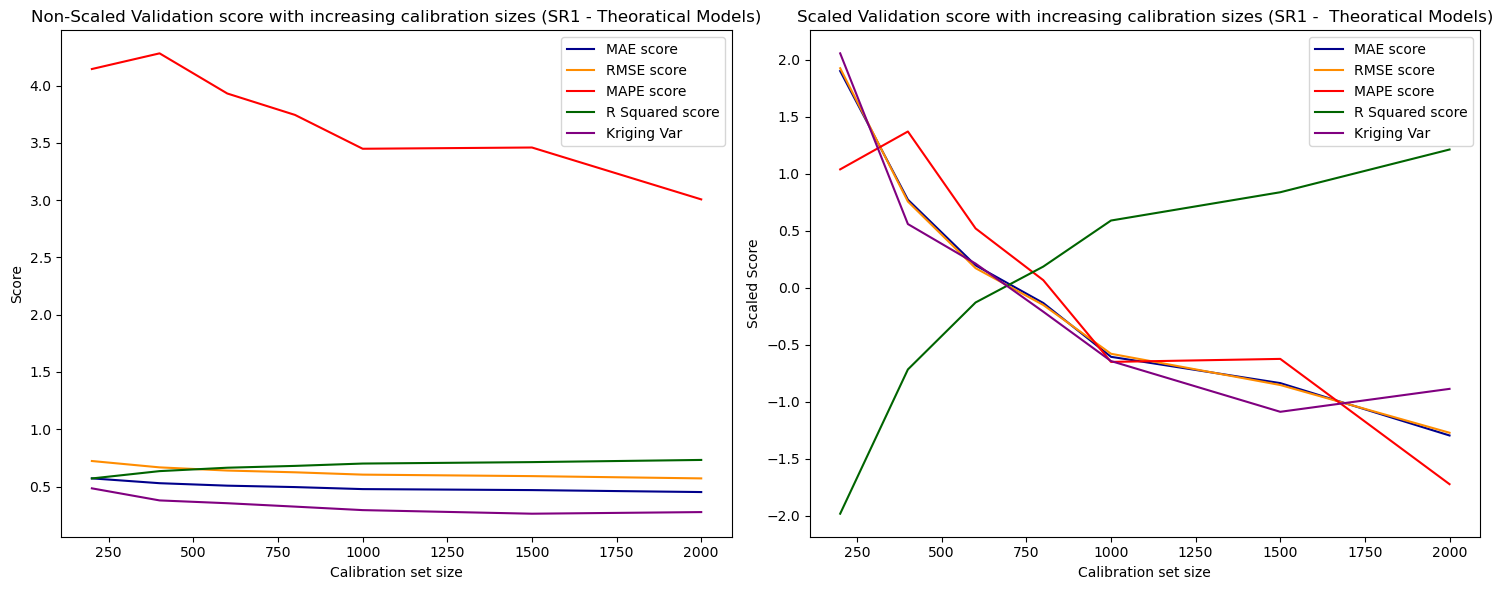

In [42]:
# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(all_means_model_df), columns=all_means_model_df.columns, index=all_means_model_df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(cal_size, all_means_model_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(cal_size, all_means_model_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(cal_size, all_means_model_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(cal_size, all_means_model_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].plot(cal_size, all_means_model_df["Validation Score Kriging Var"], color='purple', label='Kriging Var')
ax[0].set_xlabel('Calibration set size')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation score with increasing calibration sizes (SR1 - Theoratical Models)")

# Plot normalized data on the second subplot
ax[1].plot(cal_size, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(cal_size, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(cal_size, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(cal_size, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].plot(cal_size, normalized_df["Validation Score Kriging Var"], color='purple', label='Kriging Var')
ax[1].set_xlabel('Calibration set size')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation score with increasing calibration sizes (SR1 -  Theoratical Models)")

plt.tight_layout()
plt.show()

# Trend of each performance metric for each type of theoratical model as calibration set size increases

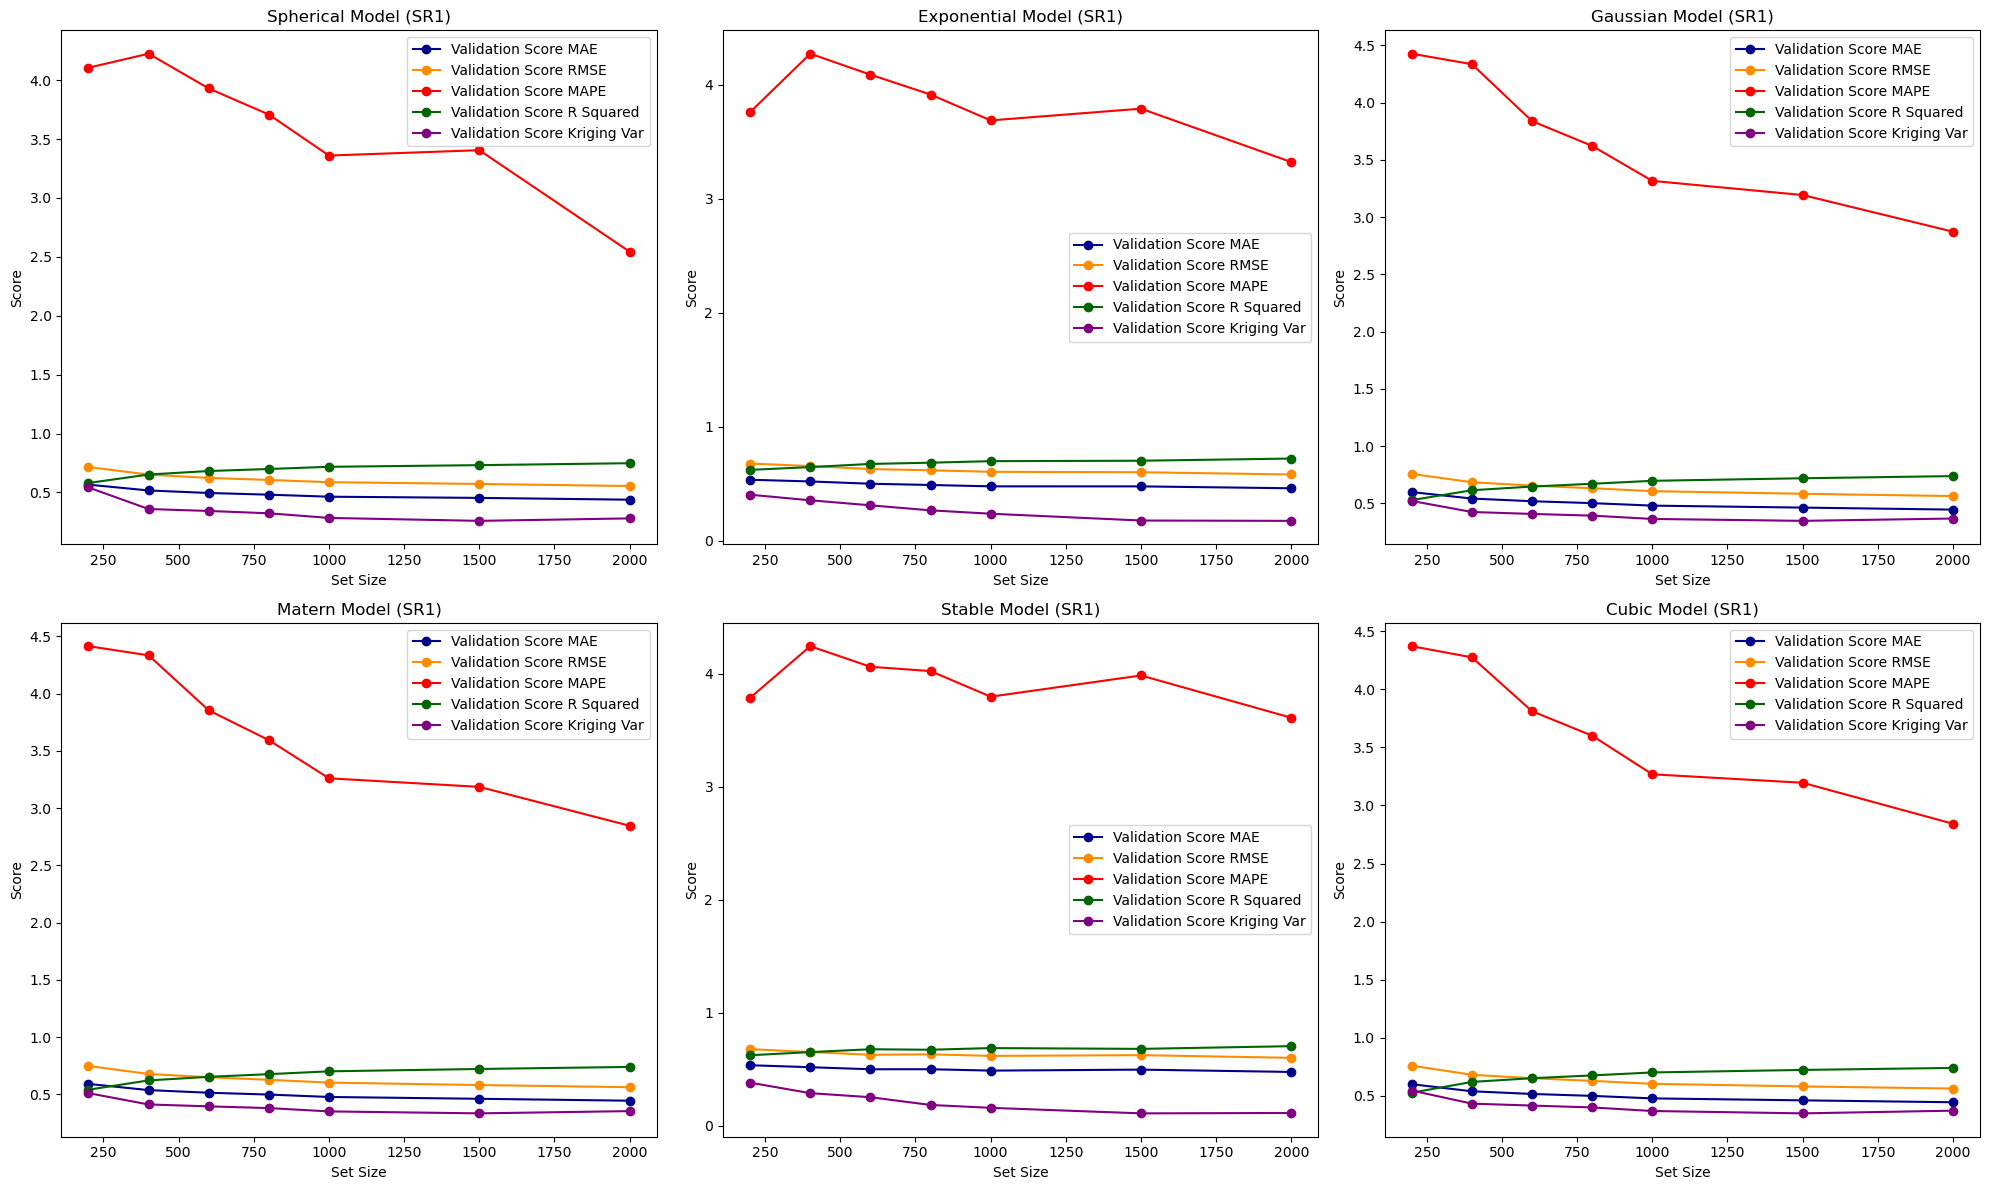

In [54]:
data_structures = {
    '200': cv_score_list_200_model,
    '400': cv_score_list_400_model,
    '600': cv_score_list_600_model,
    '800': cv_score_list_800_model,
    '1000': cv_score_list_1000_model,
    '1500': cv_score_list_1500_model,
    '2000': cv_score_list_2000_model
}

# Assuming a hypothetical structure for illustration
models = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']
validation_scores = ['Validation Score MAE', 'Validation Score RMSE', 'Validation Score MAPE', 'Validation Score R Squared', 'Validation Score Kriging Var']
colors = ['darkblue', 'darkorange', 'red', 'darkgreen', 'purple']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axs = axs.flatten()

set_sizes = [int(size) for size in data_structures.keys()]  # Extracting set sizes from the keys

for idx, model in enumerate(models):
    for score, color in zip(validation_scores, colors):
        scores = [data_structures[str(set_size)][model][score] for set_size in set_sizes]  # Extract scores for each set size
        
        # Plot on the corresponding subplot
        axs[idx].plot(set_sizes, scores, label=score, color=color, marker='o')  # Added markers for clarity

    axs[idx].set_title(f'{model.capitalize()} Model (SR1)')
    axs[idx].set_xlabel('Set Size')
    axs[idx].set_ylabel('Score')
    axs[idx].legend()

plt.tight_layout()
plt.show()

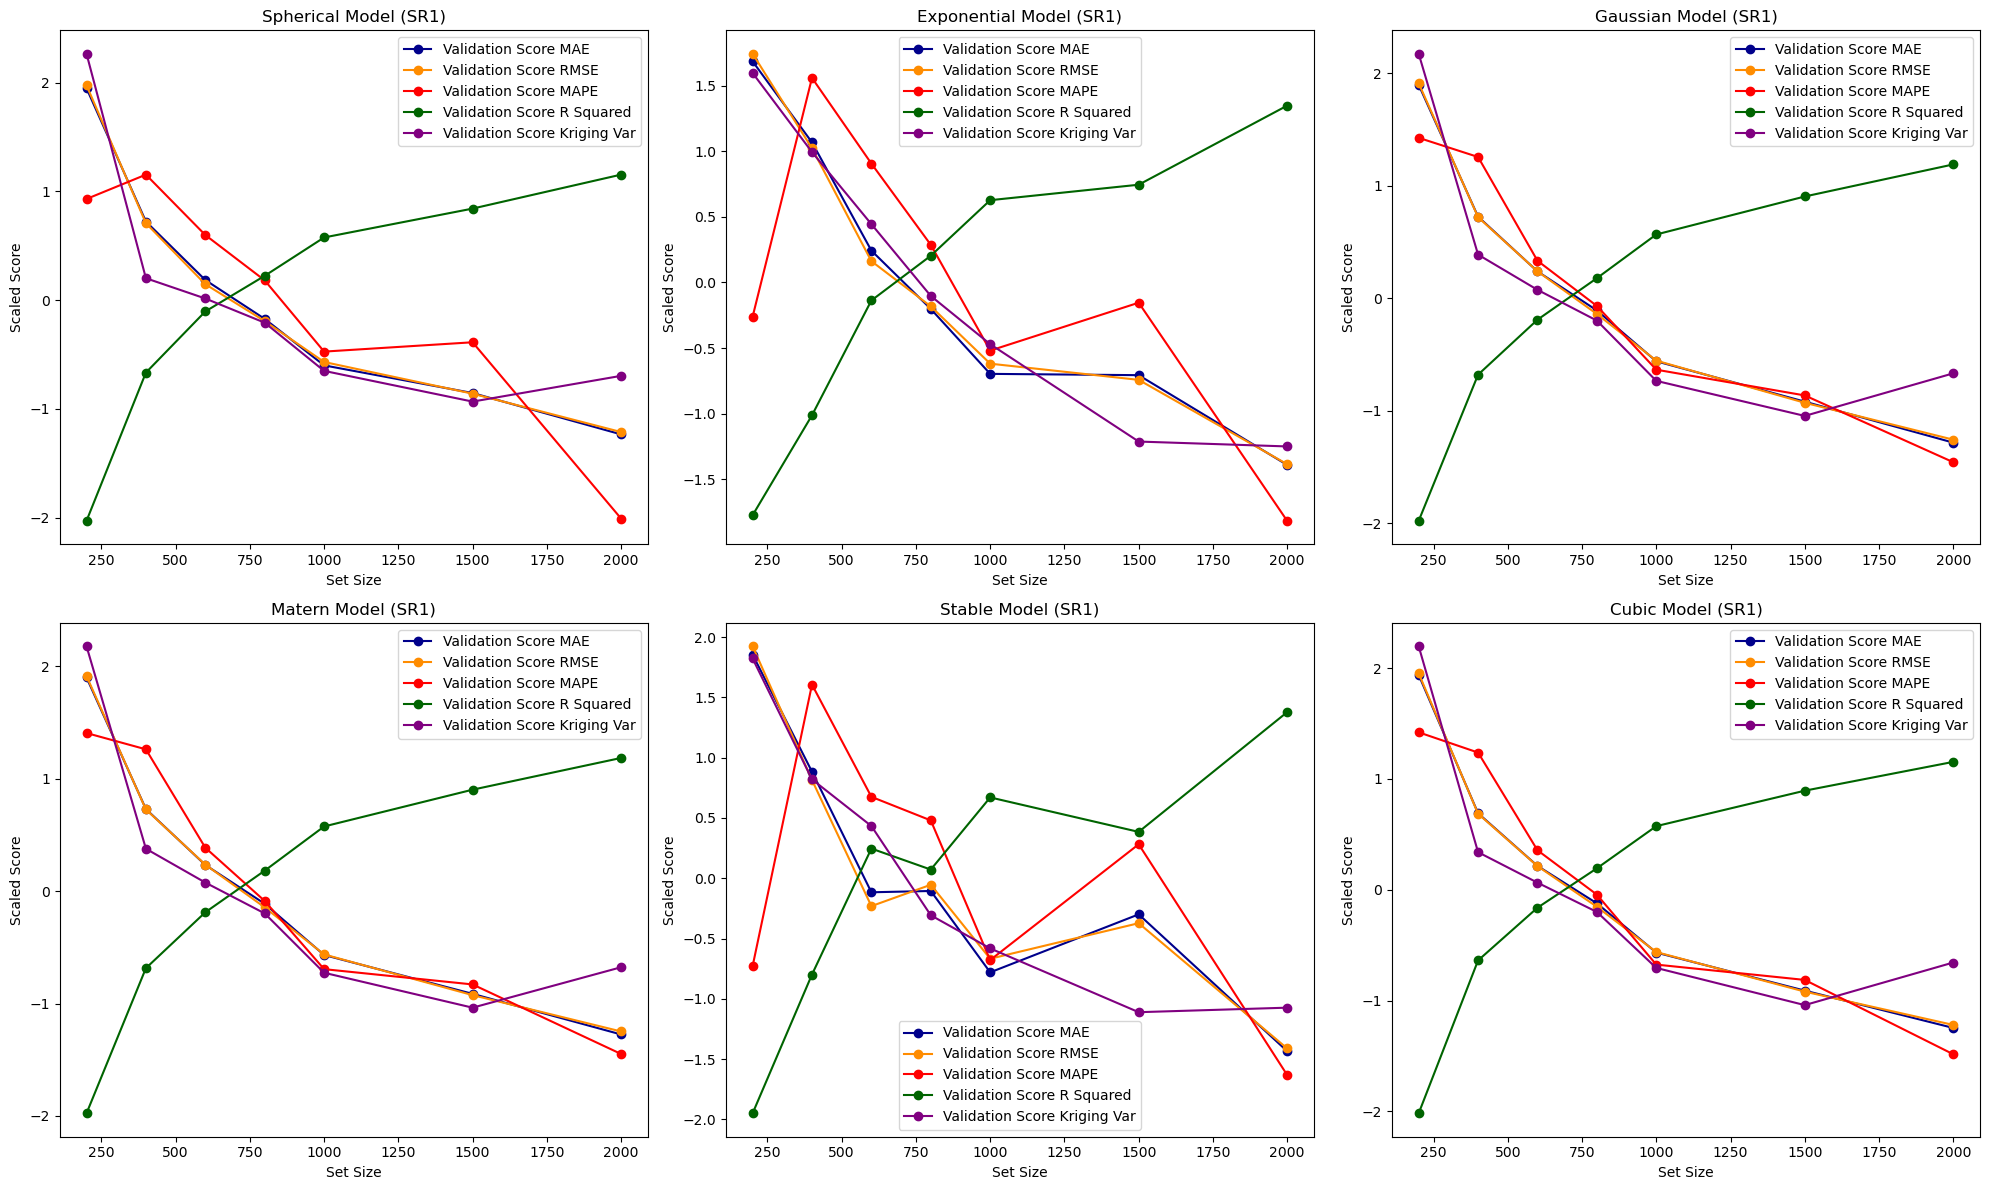

In [55]:
data_structures = {
    '200': cv_score_list_200_model,
    '400': cv_score_list_400_model,
    '600': cv_score_list_600_model,
    '800': cv_score_list_800_model,
    '1000': cv_score_list_1000_model,
    '1500': cv_score_list_1500_model,
    '2000': cv_score_list_2000_model
}

models = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']
validation_scores = ['Validation Score MAE', 'Validation Score RMSE', 'Validation Score MAPE', 'Validation Score R Squared', 'Validation Score Kriging Var']
colors = ['darkblue', 'darkorange', 'red', 'darkgreen', 'purple']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axs = axs.flatten()

set_sizes = [int(size) for size in data_structures.keys()]  # Extracting set sizes from the keys

scaler = StandardScaler()

for idx, model in enumerate(models):
    # Preparing an array for each score type to fit and transform with StandardScaler
    for score_type, color in zip(validation_scores, colors):
        # Extract scores for each set size and model
        scores_array = np.array([data_structures[str(set_size)][model][score_type] for set_size in set_sizes]).reshape(-1, 1)
        scaled_scores = scaler.fit_transform(scores_array).flatten()  # Scale and convert back to 1D array
        
        axs[idx].plot(set_sizes, scaled_scores, label=score_type, color=color, marker='o')

    axs[idx].set_title(f'{model.capitalize()} Model (SR1)')
    axs[idx].set_xlabel('Set Size')
    axs[idx].set_ylabel('Scaled Score')
    axs[idx].legend()

plt.tight_layout()
plt.show()


## Testing model (Final Performance Metrics)

In [49]:
filenames = ['SR1_input_randomfield_cal200','SR1_input_randomfield_cal400', 'SR1_input_randomfield_cal600',
             'SR1_input_randomfield_cal800', 'SR1_input_randomfield_cal1000', 'SR1_input_randomfield_cal1500', 'SR1_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
combined_df = pd.DataFrame()
for file in filenames:
    cal_df = pd.read_csv(f'Synthetic Data/SR1/cal_{file}.csv')
    combined_df = pd.concat([cal_df, combined_df], ignore_index=True)

combined_df = pd.concat([val_df, combined_df], ignore_index=True)
combined_df = combined_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

combined_df #All caliration points and validation data points

x   y         z
0     39   4 -1.774013
1     47  42 -0.393699
2     92  88 -0.462323
3     24  43  0.601361
4     37  92 -0.129720
...   ..  ..       ...
3995  93  12 -3.037629
3996  56  25  0.688154
3997  22   8 -0.676579
3998  38  35 -0.744753
3999  60  63  1.587638

[4000 rows x 3 columns]

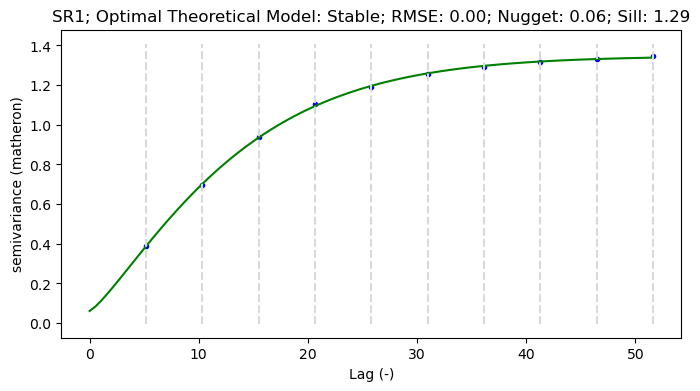

MAE: 0.4434962924615662
RMSE: 0.556698196764727
MAPE: 2.0055807952962805
R Squared: 0.7532463311325572
Mean of Kriging Var: 0.12405435070130105
Testing Computation Time: 3.02 seconds


In [50]:
eval_combined_array_coordinates = np.array([list(pair) for pair in zip(combined_df['x'], combined_df['y'])])

start_time = time.time()

V_test = skg.Variogram(eval_combined_array_coordinates, combined_df['z'],maxlag='median', 
                       use_nugget = True, fit_method = 'ml', model = 'stable')

OK = skg.OrdinaryKriging(V_test, mode='exact')

 # Predict at test locations
z_pred_test = OK.transform(test_df['x'], test_df['y'])

rmse = np.sqrt(mean_squared_error(test_df['z'], z_pred_test))
mae = mean_absolute_error(test_df['z'], z_pred_test)
mape = mean_absolute_percentage_error(test_df['z'], z_pred_test)
r2 = r2_score(test_df['z'], z_pred_test)
sigma = np.mean(OK.sigma)

end_time = time.time()

fig = V_test.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'SR1; Optimal Theoretical Model: Stable; RMSE: {V_test.rmse:.2f}; Nugget: {V_test.describe()["nugget"]:.2f}; Sill: {V_test.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print("Mean of Kriging Var:", sigma)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

### Plotting Spatial Interpolation of entire area with Model

In [52]:
filenames = ['cal_SR1_input_randomfield_cal200', 'cal_SR1_input_randomfield_cal400', 'cal_SR1_input_randomfield_cal600', 'cal_SR1_input_randomfield_cal800', 'cal_SR1_input_randomfield_cal1000', 'cal_SR1_input_randomfield_cal1500', 'cal_SR1_input_randomfield_cal2000',
            'val_SR1_input_randomfield_cal2000', 'test_SR1_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
all_df = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(f'Synthetic Data/SR1/{file}.csv')
    all_df = pd.concat([df, all_df], ignore_index=True)

all_df = all_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

all_df #All calibration, validation and test data points

x   y         z
0     83  56 -1.154367
1     40  74 -0.398708
2     90  28 -0.161047
3     51  84 -1.042425
4     32  48 -1.328360
...   ..  ..       ...
5995  93  12 -3.037629
5996  56  25  0.688154
5997  22   8 -0.676579
5998  38  35 -0.744753
5999  60  63  1.587638

[6000 rows x 3 columns]

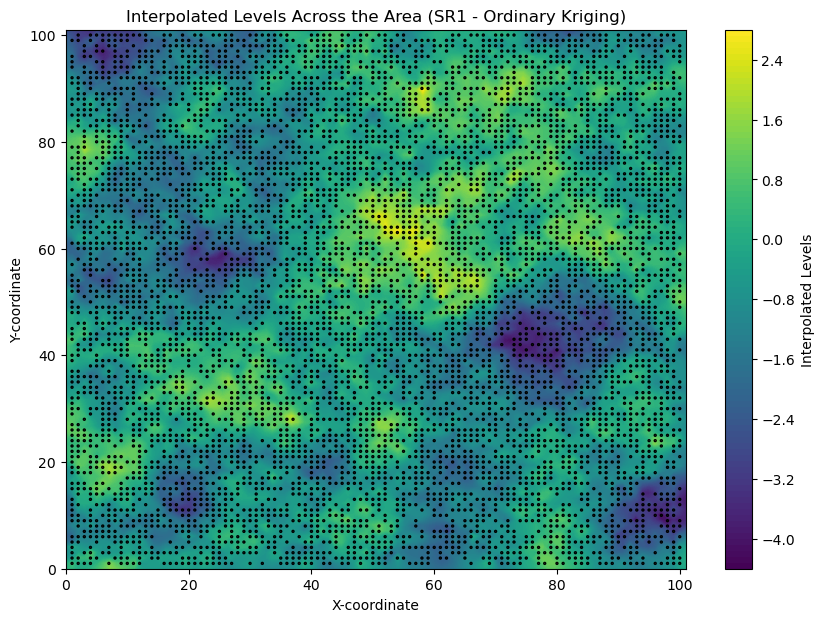

Spatial Interpolation Computation Time: 8.85 seconds


In [53]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'z'
observed_locations = all_df[observed_location_columns].values
observed_values = all_df[observed_values_column].values

# Start timing spatial interpolation
start_time_interpolation = time.time()

# Initialize IDW model
V = skg.Variogram(observed_locations, observed_values,model = 'stable',maxlag='median', use_nugget = True, fit_method = 'ml')
ok = skg.OrdinaryKriging(V, mode='exact')

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = ok.transform(grid_points)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Levels')
plt.scatter(all_df['x'], all_df['y'], c=all_df['z'], cmap='viridis', edgecolor='k', label='Observed', s= 2.0)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
#plt.legend()
plt.title('Interpolated Levels Across the Area (SR1 - Ordinary Kriging)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

Spatial Interpolation Computation Time: 4.70 seconds


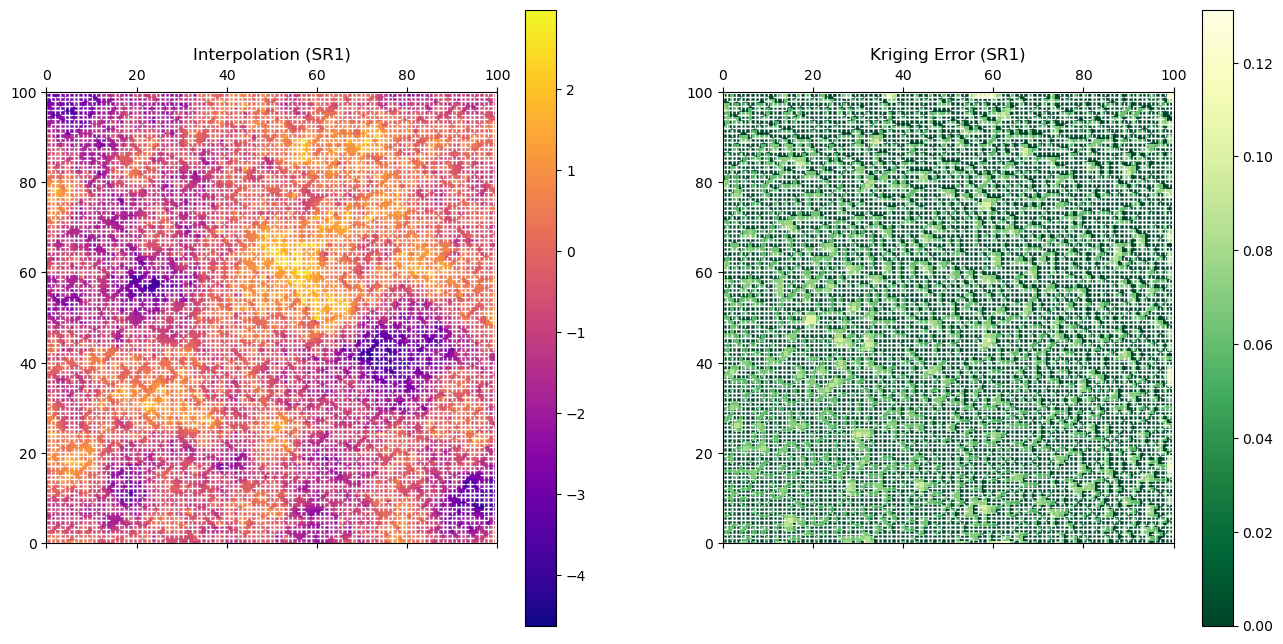

In [57]:
start_time_interpolation = time.time()
ok = skg.OrdinaryKriging(V, mode='exact')
# build the target grid
x = observed_locations[:,0]
y = observed_locations[:,1]
# xx, yy = np.mgrid[0:99:100j, 0:99:100j]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# rescale the coordinates to fit the interpolation raster
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

art = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=observed_values.min(), vmax=observed_values.max())
axes[0].set_title('Interpolation (SR1)')
axes[0].plot(x_, y_, '+w')
axes[0].set_xlim((0,100))
axes[0].set_ylim((0,100))
plt.colorbar(art, ax=axes[0])
art = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error (SR1)')
plt.colorbar(art, ax=axes[1])
axes[1].plot(x_, y_, '+w')
axes[1].set_xlim((0,100))
axes[1].set_ylim((0,100));

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")